In [1]:
import numpy as np

In [2]:
fn       = np.loadtxt('MassiveNuS_params.txt',usecols=[0],dtype=np.str)
params   = np.loadtxt('MassiveNuS_params.txt',usecols=[1,2,3])## M_nu,Omega_m,A_s*1e9
data_sim = np.array([np.load('%s_Peaks_KN_s2.00_z1.00_ng40.00_b050.npy'%(ifn))[2:] for ifn in fn])

In [3]:
def paramsFromName(fn):
    Om=float(fn.split('Om')[1].split('_')[0])
    As=float(fn.split('As')[1].split('_')[0])
    mnv=float(fn.split('mva')[1].split('_')[0])
    mnv+=float(fn.split('mvb')[1].split('_')[0])
    mnv+=float(fn.split('mvc')[1].split('_')[0])
    return mnv,Om,As


PARAMS = [paramsFromName(f) for f in fn]

In [4]:
print(params.shape)
print(data_sim.shape)

(101, 3)
(101, 9999, 50)


In [5]:
params_fid = params[51]
theta_fiducial = params_fid

In [6]:
bin_centers = np.linspace(-1.92,5.92, 50)

In [7]:
np.diff(bin_centers)

array([0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16,
       0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16,
       0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16,
       0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16,
       0.16, 0.16, 0.16, 0.16, 0.16])

In [8]:
data_sim[0,0]*0.00126899073531

array([ 0.,  0.,  1.,  0.,  0.,  2.,  1.,  3.,  4.,  1., 10., 16., 12.,
       21., 20., 27., 38., 47., 49., 36., 26., 27., 20., 31., 24., 27.,
       22., 15.,  8., 18., 10.,  5.,  5.,  3.,  4.,  2.,  1.,  0.,  1.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [9]:
means = np.mean(data_sim,axis=1)

In [10]:
std  = np.std(data_sim[0,:,:],axis=0)

In [11]:
import sys

In [12]:
sys.path.append("/home/nessa/Documents/Projects/pydelfi/") 

In [13]:
import numpy as np
import ndes.ndes as ndes
import delfi.delfi as delfi
import compression.score.score as score
import distributions.priors as priors
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
%matplotlib inline

In [14]:
theta_fiducial

array([0.1, 0.3, 2.1])

In [15]:
fid_index = 51

In [16]:
realizations_4_cov = np.load('Peaks_KN_s2.00_z1.00_ng40.00_b050.npy')
#take away last two sims of covariance
realizations_4_cov = realizations_4_cov[:-2,:]
print(realizations_4_cov.shape, data_sim.shape)

(9999, 50) (101, 9999, 50)


In [17]:
# average covariance sims
cov_sims =[]
for jj in range(np.int((realizations_4_cov.shape[0])/101)):
    cov_sims+=[np.mean(realizations_4_cov[jj*101:(jj+1)*101,:],axis=0)]
cov_sims=np.asarray(cov_sims)

In [18]:
Cov     = np.cov(cov_sims.T)
print(Cov.shape)
Cov_Inv = np.linalg.inv(Cov)

# diag = np.diag(Cov)

# diag1= np.expand_dims(diag,1)
# diag2= np.expand_dims(diag,0)

(50, 50)


In [19]:
# Cov     = np.cov(realizations_4_cov.T)
# Cov_Inv = np.linalg.inv(Cov)

# diag = np.diag(Cov)

# diag1= np.expand_dims(diag,1)
# diag2= np.expand_dims(diag,0)

In [20]:
ordered_params = []
averaged_all   = np.zeros((len(data_sim),np.int((data_sim.shape[1]+1)/101),50))
for ii in range(len(data_sim)):
    for jj in range(np.int((data_sim.shape[1])/101)):
        averaged_all[ii,jj]=np.mean(data_sim[ii,jj*101:(jj+1)*101,:],axis=0)
        ordered_params+=[PARAMS[ii]]
    
averaged_all.shape

(101, 99, 50)

In [21]:
means = np.zeros((101,50))
for jj in range(averaged_all.shape[0]):
    means[jj] = np.mean(averaged_all[jj],axis=0)



In [22]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C


kernel = C(1.0, (1e-4, 1e4)) * RBF(1, (1e-4, 1e4))
#Instanciate a Gaussian Process model
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
# Fit to data 

gp.fit(PARAMS,means)

#use the GP prediction to build the model
def fitGP(theta):
    pred, stdev = gp.predict(np.array(theta).reshape(1,3),return_std=True)
    return pred.T

h      = 0.01

theta1 = np.asarray([theta_fiducial[0]*(1+h), theta_fiducial[1],theta_fiducial[2]])
theta1_= np.asarray([theta_fiducial[0]*(1-h), theta_fiducial[1],theta_fiducial[2]])

theta2 = np.asarray([theta_fiducial[0], theta_fiducial[1]*(1+h),theta_fiducial[2]])
theta2_= np.asarray([theta_fiducial[0], theta_fiducial[1]*(1-h),theta_fiducial[2]])

theta3 = np.asarray([theta_fiducial[0], theta_fiducial[1],theta_fiducial[2]*(1+h)])
theta3_= np.asarray([theta_fiducial[0], theta_fiducial[1],theta_fiducial[2]*(1-h)])

dmudt1 = (fitGP(theta1)-fitGP(theta1_))/(theta1-theta1_)[0]
dmudt2 = (fitGP(theta2)-fitGP(theta2_))/(theta2-theta2_)[1]
dmudt3 = (fitGP(theta3)-fitGP(theta3_))/(theta3-theta3_)[2]

dmudt = np.hstack((dmudt1,dmudt2,dmudt3)).T

In [23]:
theta_fiducial = np.array(params_fid)
mu             = fitGP(theta_fiducial)[:,0]
Cinv           = Cov_Inv


Compressor     = score.Gaussian(len(mu), theta_fiducial, mu = mu, Cinv = Cinv, dmudt = dmudt)
Compressor.compute_fisher()
Finv           = Compressor.Finv

def compressor(d, compressor_args):
    return Compressor.scoreMLE(d)
compressor_args=None

In [24]:
ordered_params=[]
averaged_data =[]
averaged_train=[]
for ii in range(len(data_sim)):
    if ii==51:
        par = PARAMS[ii]
        for jj in range(np.int((data_sim.shape[1])/101)):
            averaged_data+=[np.mean(data_sim[ii,jj*101:(jj+1)*101,:],axis=0)]
    else:
         for jj in range(np.int((data_sim.shape[1])/101)):
            averaged_train+=[np.mean(data_sim[ii,jj*101:(jj+1)*101,:],axis=0)]
            ordered_params+=[PARAMS[ii]]
    
averaged_data  = np.asarray(averaged_data)
averaged_train = np.asarray(averaged_train)
ordered_params = np.asarray(ordered_params)

In [25]:
print(averaged_data.shape,averaged_train.shape, ordered_params.shape)

(99, 50) (9900, 50) (9900, 3)


In [26]:
for ii in range(len(PARAMS)):
    if PARAMS[ii][0]==0.0:
        print(ii)
        
PARAMS[51]

53


(0.09999, 0.2978, 2.1)

In [27]:
compressed_data = np.zeros((averaged_data.shape[0],3))

for ii in range(len(averaged_data)):
    compressed_data[ii] = compressor(averaged_data[ii],None)
    
compressed_train = np.zeros((averaged_train.shape[0],3))

for ii in range(len(averaged_train)):
    compressed_train[ii] = compressor(averaged_train[ii],None)

In [28]:
print(compressed_data.shape,compressed_train.shape,ordered_params.shape)

(99, 3) (9900, 3) (9900, 3)


In [30]:
# (compressed_data-compressed_data_Will)/compressed_data

In [31]:
lower = np.array([np.min(params[:,0]),np.min(params[:,1]),np.min(params[:,2])])
upper = np.array([np.max(params[:,0]),np.max(params[:,1]),np.max(params[:,2])])
# upper = np.array([1, 1.2, 0.1, 1.0, 1.3])
prior = priors.Uniform(lower, upper)

In [32]:
NDEs = [ndes.MixtureDensityNetwork(n_parameters=3, n_data=3, n_components=1, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=0),
       ndes.MixtureDensityNetwork(n_parameters=3, n_data=3, n_components=2, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=1),
       ndes.MixtureDensityNetwork(n_parameters=3, n_data=3, n_components=3, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=2),
       ndes.MixtureDensityNetwork(n_parameters=3, n_data=3, n_components=4, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=3),
       ndes.MixtureDensityNetwork(n_parameters=3, n_data=3, n_components=5, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=4),
       ndes.ConditionalMaskedAutoregressiveFlow(n_parameters=3, n_data=3, n_hiddens=[50,50], n_mades=5, act_fun=tf.tanh, index=5)]

In [33]:
# data = np.load('./compressedSims.npy')
# ordered_params_Will = data[0]
# compressed_train_Will = data[1]
# compressed_data_Will = data[2]

DelfiEnsemble = delfi.Delfi(compressed_data[0], prior, NDEs, 
                            Finv = Finv, 
                            theta_fiducial = theta_fiducial, 
                            param_limits = [lower, upper],
                            param_names = ['M_\nu', '\Omega_m', 'A_s'], 
                            results_dir = "./",
                            input_normalization="fisher")

In [36]:
compressed_data_Will.shape, compressed_data.shape

((99, 3), (100, 3))

In [54]:
print(compressed_train_Will.shape,compressed_data_Will.shape,ordered_params_Will.shape)

(9900, 3) (99, 3) (9900, 3)


In [169]:
DelfiEnsemble.load_simulations(compressed_train,ordered_params_Will)

In [170]:
DelfiEnsemble.fisher_pretraining()

In [171]:
DelfiEnsemble.train_ndes()

In [172]:
posterior_samples = DelfiEnsemble.emcee_sample()

/home/nessa/Documents/Projects/pydelfi/delfi/delfi.py:184: RuntimeWarning: divide by zero encountered in log
  lnL = np.log(L)


Removed no burn in


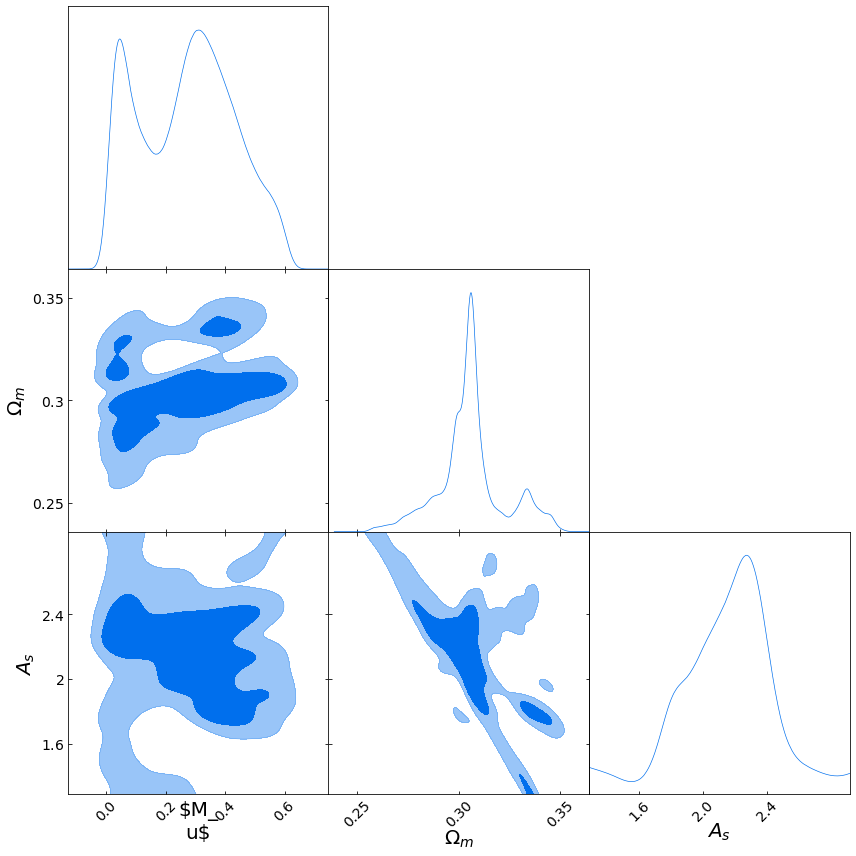

In [173]:
DelfiEnsemble.triangle_plot(samples=[posterior_samples])